In this notebook we will demonstrate different text classification models trained using the IMDB reviews dataset. 

In [1]:
# To install only the requirements of this notebook, uncomment the lines below and run this cell

# ===========================
"""
!pip install numpy==1.19.5
!pip install wget==3.2
!pip install tensorflow==1.14.0
"""

#!pip install numpy wget tensorflow tensorflow_datasets

# ===========================

#started off from: https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
#and from: https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py

'\n!pip install numpy==1.19.5\n!pip install wget==3.2\n!pip install tensorflow==1.14.0\n'

In [2]:
#Make the necessary imports
import os
import sys
import numpy as np
import tarfile
import wget
import warnings
warnings.filterwarnings("ignore") 
from zipfile import ZipFile
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

Here we set all the paths of all the external datasets and models such as [glove](https://nlp.stanford.edu/projects/glove/) and [IMDB reviews dataset](http://ai.stanford.edu/~amaas/data/sentiment/).

In [3]:
from tensorflow.keras.datasets import imdb

MAX_WORDS = 10000

# Load the IMDb dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=MAX_WORDS)

# The data comes preprocessed as sequences of word indices.
print(train_data[0])  # This will print an integer-encoded review


BASE_DIR = '../../layer-cake/.vector_cache/'

DATA_DIR = '../datasets/IMDB/'

GLOVE_DIR = os.path.join(BASE_DIR, 'GloVe')

TRAIN_DATA_DIR = DATA_DIR + '/train'
TEST_DATA_DIR = DATA_DIR + '/test'

print("GLOVE_DIR: ", GLOVE_DIR)
print("TRAIN_DATA_DIR: ", TRAIN_DATA_DIR)
print("TEST_DATA_DIR: ", TEST_DATA_DIR)

#Within these, I only have a pos/ and a neg/ folder containing text files 
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
GLOVE_DIR:  ../../layer-cake/.vector_cache/GloVe
TRAIN_DATA_

### Loading and Preprocessing
 

In [4]:
#Function to load the data from the dataset into the notebook. Will be called twice - for train and test.
"""
def get_data(data_dir):
    texts = []  # list of text samples
    labels_index = {'pos':1, 'neg':0}  # dictionary mapping label name to numeric id
    labels = []  # list of label ids
    for name in sorted(os.listdir(data_dir)):
        path = os.path.join(data_dir, name)
        if os.path.isdir(path):
            if name=='pos' or name=='neg':
                label_id = labels_index[name]
                for fname in sorted(os.listdir(path)):
                        fpath = os.path.join(path, fname)
                        text = open(fpath,encoding='utf8').read()
                        texts.append(text)
                        labels.append(label_id)
    return texts, labels

train_texts, train_labels = get_data(TRAIN_DATA_DIR)
test_texts, test_labels = get_data(TEST_DATA_DIR)
"""

train_texts, train_labels = train_data, train_labels
test_texts, test_labels = test_data, test_labels

labels_index = {'pos':1, 'neg':0} 

#Just to see how the data looks like. 
print("train_texts[0]:", train_texts[0])
print("train_labels[0]", train_labels[0])

print("test_texts[24999]:", test_texts[24999])
print("test_labels[24999]:", test_labels[24999])

train_texts[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
train_labels[0] 1
test_texts[24999]: [1, 6, 

In [5]:
#
# prep IMDB data
# 

"""
import tensorflow_datasets as tfds

# Load the IMDb dataset
imdb_data = tfds.load("imdb_reviews", as_supervised=True)

# Split the data into train and test sets
train_data, test_data = imdb_data['train'], imdb_data['test']

# Extract the reviews and labels from the dataset (decode from bytes)
train_texts = [text.decode('utf-8') for text, label in tfds.as_numpy(train_data)]
test_texts = [text.decode('utf-8') for text, label in tfds.as_numpy(test_data)]

# Extract the labels
train_labels = [label for text, label in tfds.as_numpy(train_data)]
test_labels = [label for text, label in tfds.as_numpy(test_data)]

num_classes = 2
print("num_classes:", num_classes)

# Get the class names from the 20 Newsgroups dataset
class_names = ['neg', 'pos']

y_train = train_labels
y_test = test_labels

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

classification_type = 'singlelabel'
"""

'\nimport tensorflow_datasets as tfds\n\n# Load the IMDb dataset\nimdb_data = tfds.load("imdb_reviews", as_supervised=True)\n\n# Split the data into train and test sets\ntrain_data, test_data = imdb_data[\'train\'], imdb_data[\'test\']\n\n# Extract the reviews and labels from the dataset (decode from bytes)\ntrain_texts = [text.decode(\'utf-8\') for text, label in tfds.as_numpy(train_data)]\ntest_texts = [text.decode(\'utf-8\') for text, label in tfds.as_numpy(test_data)]\n\n# Extract the labels\ntrain_labels = [label for text, label in tfds.as_numpy(train_data)]\ntest_labels = [label for text, label in tfds.as_numpy(test_data)]\n\nnum_classes = 2\nprint("num_classes:", num_classes)\n\n# Get the class names from the 20 Newsgroups dataset\nclass_names = [\'neg\', \'pos\']\n\ny_train = train_labels\ny_test = test_labels\n\ny_train = to_categorical(y_train, num_classes)\ny_test = to_categorical(y_test, num_classes)\n\nclassification_type = \'singlelabel\'\n'

In [6]:
from sklearn.datasets import fetch_20newsgroups

MAX_WORDS=20000
MAX_FEATURES=MAX_WORDS

TRAIN_TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.2

# Fetch the data with return_X_y=True returns a tuple (data, labels)
train_data, train_labels = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), return_X_y=True)
test_data, test_labels = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), return_X_y=True)

# Now, train_data and test_data contain the raw text
train_texts = train_data
test_texts = test_data

# Now, train_texts and test_texts can be fed into a tokenizer.
print("train_texts:", type(train_texts), len(train_texts))
print("train_texts[0]:", type(train_texts[0]), train_texts[0])

print("test_texts:", type(test_texts), len(test_texts))
print("test_texts[0]:", type(test_texts[0]), test_texts[0])

train_texts: <class 'list'> 11314
train_texts[0]: <class 'str'> I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
test_texts: <class 'list'> 7532
test_texts[0]: <class 'str'> I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have hea

In [7]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.utils import to_categorical

# Fetch the dataset
train_data, train_labels = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), return_X_y=True)
test_data, test_labels = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), return_X_y=True)

# Convert labels to numpy.int64
train_labels = train_labels.tolist()
test_labels = test_labels.tolist()

# Print the types and values
print("train_labels:", type(train_labels), len(train_labels))
print("train_labels[0]:", type(train_labels[0]), train_labels[0])

print("test_labels:", type(test_labels), len(test_labels))
print("test_labels[0]:", type(test_labels[0]), test_labels[0])

num_classes = 20
print("num_classes:", num_classes)

# Get the class names from the 20 Newsgroups dataset
class_names = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes')).target_names
print("class_names:", class_names)

# One-hot encode the labels
y_train = to_categorical(train_labels, num_classes)
y_test = to_categorical(test_labels, num_classes)

# Print the shape and type of one-hot encoded labels
print("y_train:", type(y_train), y_train.shape)
print("y_train[0]:", type(y_train[0]), y_train[0].shape)
print("y_train[0]:", y_train[0])

print("y_test:", type(y_test), y_test.shape)
print("y_test[0]:", type(y_test[0]), y_test[0].shape)
print("y_test[0]:", y_test[0])

classification_type = 'singlelabel'

train_labels: <class 'list'> 11314
train_labels[0]: <class 'int'> 7
test_labels: <class 'list'> 7532
test_labels[0]: <class 'int'> 7
num_classes: 20
class_names: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
y_train: <class 'numpy.ndarray'> (11314, 20)
y_train[0]: <class 'numpy.ndarray'> (20,)
y_train[0]: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
y_test: <class 'numpy.ndarray'> (7532, 20)
y_test[0]: <class 'numpy.ndarray'> (20,)
y_test[0]: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
#Vectorize these text samples into a 2D integer tensor using Keras Tokenizer 
#Tokenizer is fit on training data only, and that is used to tokenize both train and test data. 
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS) 
tokenizer.fit_on_texts(train_texts) 
train_sequences = tokenizer.texts_to_sequences(train_texts) #Converting text to a vector of word indexes 
test_sequences = tokenizer.texts_to_sequences(test_texts) 
word_index = tokenizer.word_index 
print('Found %s unique tokens.' % len(word_index))

Found 105372 unique tokens.


In [9]:
print("train_sequences:", type(train_sequences), len(train_sequences))              #This is a list of lists, one list for each review
print("train_sequences[0]:", type(train_sequences[0]), len(train_sequences[0]))     #This is a list of word indexes for the first review
print("train_sequences[0]:", train_sequences[0])                                    #This will print a list of word indexes (depends on the tokenizer)

print("test_sequences:", type(test_sequences), len(test_sequences))                       #This is a list of lists, one list for each review
print("test_sequences[0]:", type(test_sequences[0]), len(test_sequences[0]))              #This is a list of word indexes for the 25000th review
print("test_sequences[0]:", test_sequences[0])                                            #This will print a list of word indexes (depends on the tokenizer)

train_sequences: <class 'list'> 11314
train_sequences[0]: <class 'list'> 91
train_sequences[0]: [7, 26, 1383, 24, 160, 64, 43, 105, 11322, 61, 15, 14, 312, 7, 587, 1, 73, 262, 11, 26, 5, 29, 1282, 2507, 312, 986, 3, 16, 30, 1, 1203, 11907, 748, 13307, 11, 26, 288, 5, 1, 3721, 68, 172, 408, 8, 1107, 1, 799, 7710, 26, 1604, 30, 1, 691, 4, 1, 641, 14, 9, 40, 7, 86, 24, 160, 38, 5, 657, 236, 959, 3069, 179, 4, 2570, 141, 14, 312, 9, 201, 533, 23, 720, 352, 13, 18, 15, 14, 18059, 357, 312, 167, 101, 206]
test_sequences: <class 'list'> 7532
test_sequences[0]: <class 'list'> 89
test_sequences[0]: [7, 123, 5, 249, 3289, 15, 40, 4, 1, 1415, 4, 1, 2335, 2538, 7, 18, 387, 4, 1, 4348, 1729, 105, 248, 272, 61, 1, 1918, 17, 278, 21, 1307, 23, 914, 7, 123, 90, 2730, 3, 86, 44, 1, 382, 595, 9, 12, 1, 2538, 657, 6, 87, 128, 325, 92, 382, 595, 38, 13, 580, 81, 84, 12, 8, 73, 635, 87, 128, 17, 27, 8, 2435, 14, 96, 4, 175, 7, 18, 387, 10, 1, 2584, 2691, 748, 1452, 9, 1, 260, 96, 3, 506]


In [10]:
#Converting this to sequences to be fed into neural network. Max seq. len is 1000 as set earlier
#initial padding of 0s, until vector is of size MAX_SEQUENCE_LENGTH
trainvalid_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
trainvalid_labels = to_categorical(np.asarray(train_labels))
test_labels = to_categorical(np.asarray(test_labels))

print("trainvalid_data:", type(trainvalid_data), trainvalid_data.shape)                         #Will print a 2D tensor
print("trainvalid_data[0]:", type(trainvalid_data[0]), trainvalid_data[0].shape)                #Will print a 1D tensor
print("trainvalid_data[0]:", trainvalid_data[0])                                                #Will print a 1D tensor with values as indexes

print("test_data:", type(test_data), test_data.shape)                               #Will print a 2D tensor
print("test_data[0]:", type(test_data[0]), test_data[0].shape)                      #Will print a 1D tensor
print("test_data[0]:\n", test_data[0])                                                #Will print a 1D tensor with values as indexes

trainvalid_data: <class 'numpy.ndarray'> (11314, 1000)
trainvalid_data[0]: <class 'numpy.ndarray'> (1000,)
trainvalid_data[0]: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0    

In [11]:
# split the training data into a training set and a validation set
indices = np.arange(trainvalid_data.shape[0])
print("indices:", type(indices), indices.shape)
print("indices[0]:", type(indices[0]), indices[0].shape)
print("indices[0]:", indices[0])

np.random.shuffle(indices)

trainvalid_data = trainvalid_data[indices]
trainvalid_labels = trainvalid_labels[indices]

num_validation_samples = int(VALIDATION_SPLIT * trainvalid_data.shape[0])
print("num_validation_samples:", num_validation_samples)

x_train = trainvalid_data[:-num_validation_samples]
y_train = trainvalid_labels[:-num_validation_samples]
x_val = trainvalid_data[-num_validation_samples:]
y_val = trainvalid_labels[-num_validation_samples:]

#This is the data we will use for CNN and RNN training

print("x_train:", type(x_train), x_train.shape)
print("y_train:", type(y_train), y_train.shape)
print("x_val:", type(x_val), x_val.shape)
print("y_val:", type(y_val), y_val.shape)

indices: <class 'numpy.ndarray'> (11314,)
indices[0]: <class 'numpy.int64'> ()
indices[0]: 0
num_validation_samples: 2262
x_train: <class 'numpy.ndarray'> (9052, 1000)
y_train: <class 'numpy.ndarray'> (9052, 20)
x_val: <class 'numpy.ndarray'> (2262, 1000)
y_val: <class 'numpy.ndarray'> (2262, 20)


In [12]:
print('Preparing embedding matrix.')

GLOVE_MODEL = 'glove.6B.100d.txt'
print("GLOVE_MODEL: ", GLOVE_MODEL)

# first, build index mapping words in the embeddings set
# to their embedding vector
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, GLOVE_MODEL),encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors in Glove embeddings.' % len(embeddings_index))
#print(embeddings_index["google"])

# prepare embedding matrix - rows are the words from word_index, columns are the embeddings of that word from glove.
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load these pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
print("Preparing of embedding matrix is done")

print("embedding_layer:", type(embedding_layer))
print("embedding_layer config:\n", embedding_layer.get_config())

Preparing embedding matrix.
GLOVE_MODEL:  glove.6B.100d.txt
Found 400000 word vectors in Glove embeddings.
Preparing of embedding matrix is done
embedding_layer: <class 'keras.layers.core.embedding.Embedding'>
embedding_layer config:
 {'name': 'embedding', 'trainable': False, 'dtype': 'float32', 'batch_input_shape': (None, 1000), 'input_dim': 20001, 'output_dim': 100, 'embeddings_initializer': {'class_name': 'Constant', 'config': {'value': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.76302999,  0.082913  ,  0.18726   , ...,  0.40522   ,
        -0.25400999, -0.71917999],
       [-0.71047997,  0.67818999,  0.54196   , ..., -1.40209997,
        -0.41898   , -0.04331   ],
       [-0.55242002,  0.34547001,  0.2873399

### 1D CNN Model with pre-trained embedding

In [13]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

# Function to detect and set the best available device
def set_device():
    if tf.config.list_physical_devices('GPU'):
        print("Using GPU (CUDA)")
        return "/device:GPU:0"
    elif tf.config.list_physical_devices('MPS'):
        print("Using Apple MPS (Metal Performance Shaders)")
        return "/device:GPU:0"  # MPS is identified as a GPU device in TensorFlow
    else:
        print("Using CPU")
        return "/device:CPU:0"
    
# Set the device
device_name = set_device()
print("Running on device:", device_name)


# Custom F1 Score Callback
class F1ScoreCallback(Callback):

    def __init__(self, validation_data, threshold=0.5):
        super().__init__()
        self.validation_data = validation_data
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_data, val_labels = self.validation_data
        
        """
        print("val_data:", type(val_data), val_data.shape)
        print("val_data[0]:", val_data[0])
        print("val_labels:", type(val_labels), val_labels.shape)
        print("val_labels[0]:", val_labels[0])
        """

        val_predictions = self.model.predict(val_data)
        #print("val_predictions:", type(val_predictions), val_predictions.shape)
        #print("val_predictions[0]:", val_predictions[0])

        # Thresholding for multi-label classification
        val_pred_classes = (val_predictions > self.threshold).astype(int)
        #print("val_pred_classes:", type(val_pred_classes), val_pred_classes.shape)
        #print("val_pred_classes[0]:", val_pred_classes[0])

        # Calculate macro and micro F1 scores
        macro_f1 = f1_score(val_labels, val_pred_classes, average='macro')
        micro_f1 = f1_score(val_labels, val_pred_classes, average='micro')
        
        # Log F1 scores
        print(f"Epoch {epoch + 1}: Macro F1 Score = {macro_f1:.4f}, Micro F1 Score = {micro_f1:.4f}")

Using GPU (CUDA)
Running on device: /device:GPU:0


In [14]:
EPOCHS = 50
BATCH_SIZE = 128

from sklearn.utils.class_weight import compute_class_weight

# Callbacks for learning rate refinement, early stopping, and F1 score tracking
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

f1_callback = F1ScoreCallback(validation_data=(test_data, test_labels))                     # Custom F1 score callback

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("class_weights_dict:\n", class_weights_dict)

class_weights_dict:
 {0: 1.1785416666666666, 1: 0.9686643835616439, 2: 0.9571912013536379, 3: 0.9588135593220339, 4: 0.978719723183391, 5: 0.9539629005059022, 6: 0.967008547008547, 7: 0.9523569023569024, 8: 0.9459866220735786, 9: 0.9475711892797319, 10: 0.9428333333333333, 11: 0.9507563025210084, 12: 0.9571912013536379, 13: 0.9523569023569024, 14: 0.9539629005059022, 15: 0.94440734557596, 16: 1.0360805860805862, 17: 1.0030141843971632, 18: 1.2165591397849462, 19: 1.5005305039787797}


In [15]:
import matplotlib.pyplot as plt

def plot_history(history):

    print(f'plotting history: {history}')

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.clf()

    acc = history.history["acc"]
    val_acc = history.history["val_acc"]

    plt.plot(epochs, acc, "bo", label="Training accuracy")
    plt.plot(epochs, val_acc, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

In [16]:
print("labels_index:", labels_index)
print("class_names:", class_names) 
print("num_classes:", num_classes)

labels_index: {'pos': 1, 'neg': 0}
class_names: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
num_classes: 20


Define a 1D CNN model.
Epoch 1/50


2024-10-19 07:01:23.941720: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


236/236 [==============================] - 1s 4ms/step
Epoch 1: Macro F1 Score = 0.0371, Micro F1 Score = 0.0510
71/71 [==============================] - 3s 39ms/step - loss: 2.7858 - acc: 0.1220 - val_loss: 2.3753 - val_acc: 0.2065 - lr: 0.0010
Epoch 2/50
236/236 [==============================] - 1s 4ms/step
Epoch 2: Macro F1 Score = 0.0913, Micro F1 Score = 0.1519
71/71 [==============================] - 2s 31ms/step - loss: 2.2101 - acc: 0.2641 - val_loss: 2.1704 - val_acc: 0.2613 - lr: 0.0010
Epoch 3/50
236/236 [==============================] - 1s 4ms/step
Epoch 3: Macro F1 Score = 0.2388, Micro F1 Score = 0.3216
71/71 [==============================] - 2s 31ms/step - loss: 1.8359 - acc: 0.3817 - val_loss: 1.9137 - val_acc: 0.3758 - lr: 0.0010
Epoch 4/50
236/236 [==============================] - 1s 4ms/step
Epoch 4: Macro F1 Score = 0.3256, Micro F1 Score = 0.3815
71/71 [==============================] - 2s 32ms/step - loss: 1.5898 - acc: 0.4693 - val_loss: 1.6519 - val_acc: 0.4

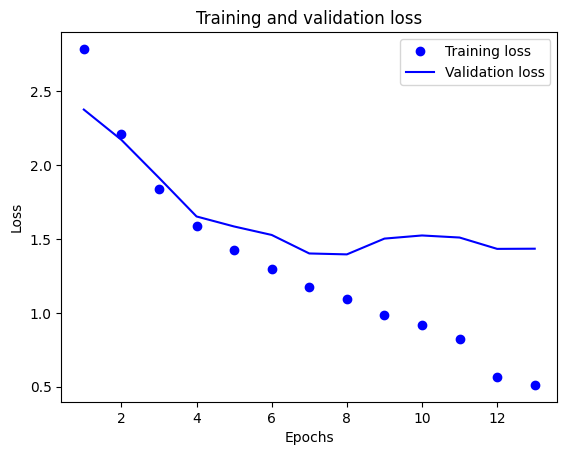

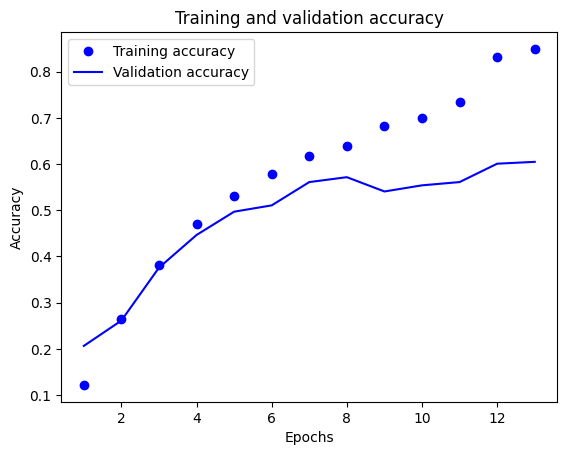

In [17]:
print('Define a 1D CNN model.')

from sklearn.metrics import f1_score, classification_report

with tf.device(device_name):

    cnnmodel = Sequential()
    cnnmodel.add(embedding_layer)
    cnnmodel.add(Conv1D(128, 5, activation='relu'))
    cnnmodel.add(MaxPooling1D(5))
    cnnmodel.add(Conv1D(128, 5, activation='relu'))
    cnnmodel.add(MaxPooling1D(5))
    cnnmodel.add(Conv1D(128, 5, activation='relu'))
    cnnmodel.add(GlobalMaxPooling1D())
    cnnmodel.add(Dense(128, activation='relu'))
    cnnmodel.add(Dense(num_classes, activation='softmax'))

    cnnmodel.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['acc'])
    
    """
    #Train the model. Tune to validation set. 
    cnnmodel.fit(x_train, y_train,
            batch_size=128,
            epochs=10, validation_data=(x_val, y_val))
    """

    # Then pass class_weights_dict to the fit function
    history = cnnmodel.fit(
        x_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(x_val, y_val),
        callbacks=[reduce_lr, early_stop, f1_callback],
        class_weight=class_weights_dict
        )
    
print("history:", type(history), history.history.keys())


plot_history(history)

In [18]:
#Evaluate on test set:
score, acc = cnnmodel.evaluate(test_data, test_labels)
print("score:", score)
print('Test accuracy with CNN:', acc)


test_preds = cnnmodel.predict(test_data)
        
# Thresholding for multi-label classification
test_pred_classes = (test_preds > .5).astype(int)

# Classification report with class labels and four decimal places
report = classification_report(test_labels, test_pred_classes, target_names=class_names, digits=4)
print("\nClassification Report:\n", report)

# Calculate macro and micro F1 scores
macro_f1 = f1_score(y_test, test_pred_classes, average='macro')
micro_f1 = f1_score(y_test, test_pred_classes, average='micro')

# Log F1 scores
print(f"\n\tMacro F1 Score = {macro_f1:.4f}, Micro F1 Score = {micro_f1:.4f}")

236/236 [==============================] - 2s 8ms/step - loss: 1.5820 - acc: 0.5722
score: 1.5819611549377441
Test accuracy with CNN: 0.5722251534461975
236/236 [==============================] - 1s 5ms/step

Classification Report:
                           precision    recall  f1-score   support

             alt.atheism     0.4539    0.2006    0.2783       319
           comp.graphics     0.7168    0.5270    0.6074       389
 comp.os.ms-windows.misc     0.6077    0.4797    0.5362       394
comp.sys.ibm.pc.hardware     0.5068    0.2857    0.3654       392
   comp.sys.mac.hardware     0.5042    0.3091    0.3833       385
          comp.windows.x     0.7180    0.5544    0.6257       395
            misc.forsale     0.7986    0.6000    0.6852       390
               rec.autos     0.7969    0.5152    0.6258       396
         rec.motorcycles     0.6500    0.6206    0.6350       398
      rec.sport.baseball     0.9201    0.7254    0.8113       397
        rec.sport.hockey     0.9284    0

### 1D CNN model with training your own embedding

In [19]:
print("y_train:", type(y_train), y_train.shape)
print("y_train[0]:", y_train[0])

print("x_train:", type(x_train), x_train.shape)
print("x_train[0]:\n", x_train[0])

y_train: <class 'numpy.ndarray'> (9052, 20)
y_train[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
x_train: <class 'numpy.ndarray'> (9052, 1000)
x_train[0]:
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0  

Using device: /device:GPU:0
Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings
Epoch 1/50
236/236 [==============================] - 1s 4ms/step
Epoch 1: Macro F1 Score = 0.0008, Micro F1 Score = 0.0008
71/71 [==============================] - 5s 63ms/step - loss: 2.9321 - acc: 0.0672 - val_loss: 2.6991 - val_acc: 0.1048 - lr: 0.0010
Epoch 2/50
236/236 [==============================] - 2s 7ms/step
Epoch 2: Macro F1 Score = 0.0196, Micro F1 Score = 0.0293
71/71 [==============================] - 5s 71ms/step - loss: 2.5320 - acc: 0.1267 - val_loss: 2.4504 - val_acc: 0.1525 - lr: 0.0010
Epoch 3/50
236/236 [==============================] - 2s 7ms/step
Epoch 3: Macro F1 Score = 0.0180, Micro F1 Score = 0.0224
71/71 [==============================] - 5s 71ms/step - loss: 2.2658 - acc: 0.2016 - val_loss: 2.4243 - val_acc: 0.1742 - lr: 0.0010
Epoch 4/50
236/236 [==============================] - 1s 3ms/step
Epoch 4: Macro F1 Score 

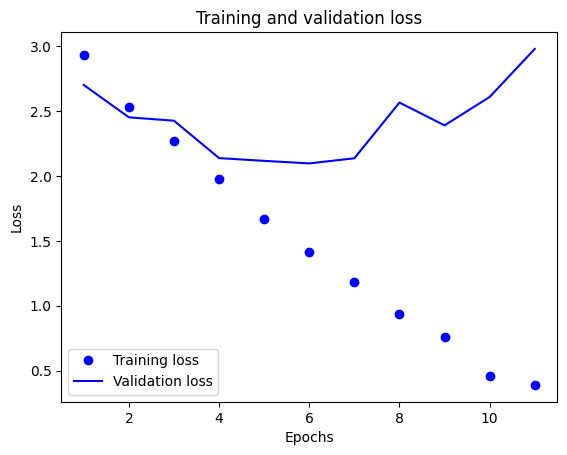

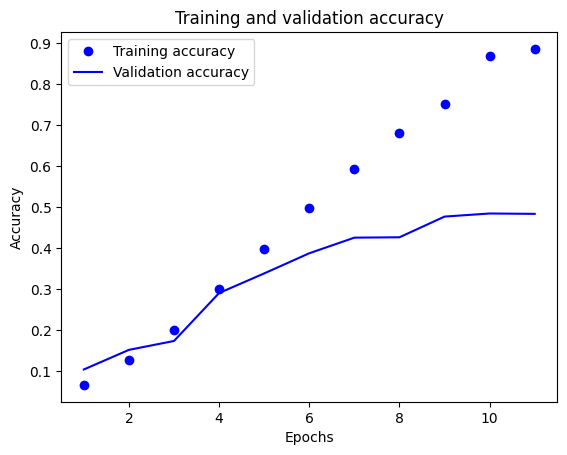

In [20]:
print(f"Using device: {device_name}")

print("Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings")

# Define the CNN model
cnnmodel = Sequential()

# Force the Embedding layer to run on the CPU
with tf.device('/CPU:0'):
    cnnmodel.add(Embedding(MAX_NUM_WORDS, 128, input_length=MAX_SEQUENCE_LENGTH))

# Rest of the model can run on the GPU
with tf.device(device_name):
    cnnmodel.add(Conv1D(128, 5, activation='relu'))
    cnnmodel.add(MaxPooling1D(5))
    cnnmodel.add(Conv1D(128, 5, activation='relu'))
    cnnmodel.add(MaxPooling1D(5))
    cnnmodel.add(Conv1D(128, 5, activation='relu'))
    cnnmodel.add(GlobalMaxPooling1D())
    cnnmodel.add(Dense(128, activation='relu'))
    cnnmodel.add(Dense(num_classes, activation='softmax'))

    cnnmodel.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['acc'])

    #Train the model. Tune to validation set. 
    history2 = cnnmodel.fit(
        x_train, 
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS, 
        validation_data=(x_val, y_val),
        callbacks=[reduce_lr, early_stop, f1_callback],
        class_weight=class_weights_dict
        )
    
print("history2:", type(history2), history2.history.keys())
plot_history(history2)

In [21]:
#Evaluate on test set:
score, acc = cnnmodel.evaluate(test_data, test_labels)
print("score:", score)
print('Test accuracy with CNN:', acc)


test_preds = cnnmodel.predict(test_data)
        
# Thresholding for multi-label classification
test_pred_classes = (test_preds > .5).astype(int)

# Classification report with class labels and four decimal places
report = classification_report(test_labels, test_pred_classes, target_names=class_names, digits=4)
print("\nClassification Report:\n", report)

# Calculate macro and micro F1 scores
macro_f1 = f1_score(y_test, test_pred_classes, average='macro')
micro_f1 = f1_score(y_test, test_pred_classes, average='micro')

# Log F1 scores
print(f"\n\tMacro F1 Score = {macro_f1:.4f}, Micro F1 Score = {micro_f1:.4f}")


236/236 [==============================] - 2s 10ms/step - loss: 3.6066 - acc: 0.4363
score: 3.6065568923950195
Test accuracy with CNN: 0.43627190589904785
236/236 [==============================] - 1s 4ms/step

Classification Report:
                           precision    recall  f1-score   support

             alt.atheism     0.3544    0.3166    0.3344       319
           comp.graphics     0.4350    0.2751    0.3370       389
 comp.os.ms-windows.misc     0.5468    0.3858    0.4524       394
comp.sys.ibm.pc.hardware     0.2430    0.1556    0.1897       392
   comp.sys.mac.hardware     0.5467    0.5325    0.5395       385
          comp.windows.x     0.7016    0.6785    0.6898       395
            misc.forsale     0.5809    0.3590    0.4437       390
               rec.autos     0.4035    0.3535    0.3769       396
         rec.motorcycles     0.3861    0.2940    0.3338       398
      rec.sport.baseball     0.7318    0.5567    0.6323       397
        rec.sport.hockey     0.8208   

### LSTM Model with training your own embedding 

In [22]:
physical_devices = tf.config.list_physical_devices('GPU')
print("physical_devices:", physical_devices)

if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        print(f'Error: {e}')

physical_devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Error: Physical devices cannot be modified after being initialized


In [23]:
tf.debugging.set_log_device_placement(True)

In [24]:
print("Defining and training an LSTM model, training embedding layer on the fly")

LSTM_BATCH_SIZE = 32

# Define the RNN model
rnnmodel = Sequential()

# Force the Embedding layer to run on the CPU
with tf.device('/CPU:0'):
        rnnmodel.add(Embedding(MAX_NUM_WORDS, 128))
        
with tf.device(device_name):
        #rnnmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
        rnnmodel.add(LSTM(128, dropout=0.2))
        rnnmodel.add(Dense(num_classes, activation='sigmoid'))

rnnmodel.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
        )

print('Training the RNN')

rnnmodel.fit(
  x_train, 
  y_train,
  batch_size=LSTM_BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=(x_val, y_val),
  callbacks=[reduce_lr, early_stop, f1_callback],
  class_weight=class_weights_dict
)

Defining and training an LSTM model, training embedding layer on the fly
Training the RNN
Epoch 1/50
236/236 [==============================] - 5s 18ms/step
Epoch 1: Macro F1 Score = 0.0000, Micro F1 Score = 0.0000
283/283 [==============================] - 27s 91ms/step - loss: 0.2180 - accuracy: 0.0531 - val_loss: 0.1982 - val_accuracy: 0.0570 - lr: 0.0010
Epoch 2/50
236/236 [==============================] - 4s 18ms/step
Epoch 2: Macro F1 Score = 0.0119, Micro F1 Score = 0.0134
283/283 [==============================] - 25s 90ms/step - loss: 0.1932 - accuracy: 0.1233 - val_loss: 0.1920 - val_accuracy: 0.1251 - lr: 0.0010
Epoch 3/50
236/236 [==============================] - 4s 19ms/step
Epoch 3: Macro F1 Score = 0.0525, Micro F1 Score = 0.0553
283/283 [==============================] - 25s 89ms/step - loss: 0.1751 - accuracy: 0.3151 - val_loss: 0.1834 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 4/50
236/236 [==============================] - 4s 18ms/step
Epoch 4: Macro F1 Score = 0.08

In [25]:
#Evaluate on test set:
score, acc = rnnmodel.evaluate(test_data, test_labels)
print("score:", score)
print('Test accuracy with CNN:', acc)

test_preds = rnnmodel.predict(test_data)
        
# Thresholding for multi-label classification
test_pred_classes = (test_preds > .5).astype(int)

# Classification report with class labels and four decimal places
report = classification_report(test_labels, test_pred_classes, target_names=class_names, digits=4)
print("\nClassification Report:\n", report)

# Calculate macro and micro F1 scores
macro_f1 = f1_score(y_test, test_pred_classes, average='macro')
micro_f1 = f1_score(y_test, test_pred_classes, average='micro')

# Log F1 scores
print(f"\n\tMacro F1 Score = {macro_f1:.4f}, Micro F1 Score = {micro_f1:.4f}")

236/236 [==============================] - 5s 21ms/step - loss: 0.1791 - accuracy: 0.2914
score: 0.17913109064102173
Test accuracy with CNN: 0.2914232611656189
236/236 [==============================] - 4s 19ms/step

Classification Report:
                           precision    recall  f1-score   support

             alt.atheism     0.3750    0.1034    0.1622       319
           comp.graphics     0.1964    0.0566    0.0878       389
 comp.os.ms-windows.misc     0.4667    0.0888    0.1493       394
comp.sys.ibm.pc.hardware     0.2842    0.0689    0.1109       392
   comp.sys.mac.hardware     0.4513    0.1325    0.2048       385
          comp.windows.x     0.4407    0.1316    0.2027       395
            misc.forsale     0.7391    0.4795    0.5816       390
               rec.autos     0.3760    0.1187    0.1804       396
         rec.motorcycles     0.4650    0.2337    0.3110       398
      rec.sport.baseball     0.5730    0.2569    0.3548       397
        rec.sport.hockey     0.5

### LSTM Model using pre-trained Embedding Layer

In [ ]:
print("Defining and training an LSTM model, using pre-trained embedding layer")

rnnmodel2 = Sequential()
rnnmodel2.add(embedding_layer)
#rnnmodel2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
rnnmodel2.add(LSTM(128, dropout=0.2))
rnnmodel2.add(Dense(num_classes, activation='sigmoid'))

rnnmodel2.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
  )

print('Training the RNN')

history3 = rnnmodel2.fit(
  x_train, 
  y_train,
  batch_size=LSTM_BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=(x_val, y_val),
  callbacks=[reduce_lr, early_stop, f1_callback],
  class_weight=class_weights_dict
  )

Defining and training an LSTM model, using pre-trained embedding layer
Training the RNN
Epoch 1/50
236/236 [==============================] - 4s 17ms/step
Epoch 1: Macro F1 Score = 0.0000, Micro F1 Score = 0.0000
283/283 [==============================] - 23s 77ms/step - loss: 0.2064 - accuracy: 0.0824 - val_loss: 0.1848 - val_accuracy: 0.1331 - lr: 0.0010
Epoch 2/50
226/283 [======================>.......] - ETA: 3s - loss: 0.1735 - accuracy: 0.1757

In [28]:
print("history:", type(history3), history3.history.keys())
#plot_history(history3)

history: <class 'keras.callbacks.History'> dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [29]:
#Evaluate on test set:
score, acc = rnnmodel2.evaluate(test_data, test_labels, batch_size=LSTM_BATCH_SIZE)
print("score:", score)
print('Test accuracy with CNN:', acc)

test_preds = rnnmodel2.predict(test_data)
        
# Thresholding for multi-label classification
test_pred_classes = (test_preds > .5).astype(int)

# Classification report with class labels and four decimal places
report = classification_report(test_labels, test_pred_classes, target_names=class_names, digits=4)
print("\nClassification Report:\n", report)

# Calculate macro and micro F1 scores
macro_f1 = f1_score(y_test, test_pred_classes, average='macro')
micro_f1 = f1_score(y_test, test_pred_classes, average='micro')

# Log F1 scores
print(f"\n\tMacro F1 Score = {macro_f1:.4f}, Micro F1 Score = {micro_f1:.4f}")

236/236 [==============================] - 4s 17ms/step - loss: 0.1952 - accuracy: 0.1049
score: 0.19518542289733887
Test accuracy with CNN: 0.10488582402467728
236/236 [==============================] - 4s 17ms/step

Classification Report:
                           precision    recall  f1-score   support

             alt.atheism     0.0000    0.0000    0.0000       319
           comp.graphics     0.0000    0.0000    0.0000       389
 comp.os.ms-windows.misc     0.0000    0.0000    0.0000       394
comp.sys.ibm.pc.hardware     0.0000    0.0000    0.0000       392
   comp.sys.mac.hardware     0.0000    0.0000    0.0000       385
          comp.windows.x     0.0000    0.0000    0.0000       395
            misc.forsale     0.0000    0.0000    0.0000       390
               rec.autos     0.0000    0.0000    0.0000       396
         rec.motorcycles     0.0000    0.0000    0.0000       398
      rec.sport.baseball     0.0000    0.0000    0.0000       397
        rec.sport.hockey     0.